# Search coined algorithm : NxN grid

In this notebook, we are presenting an application of quantum search on a NxN grid (boundary conditions are modulo N). The grid is a graph where every vertex has 4 neigbors which are the adjacents square of the grid.

To search a marked element in the grid, we walk the grid with a coin. This coin is disturbed when we apply it on the marked vertex.

We will introduce 2 search algorithm on the graph : with the moving shift and with a flip-flop shift.

### References : 

- Ambainis, A., Kempe, J., Rivosh, A. (2005): Coins make quantum walks faster.
- Portugal, R. (2019). Quantum Walks and Search Algorithms - Second Edition (Softcover reprint of the original 2nd ed. 2018 éd.). Springer.
- Jiangfeng Du, Chao Lei, Gan Qin, Dawei Lu and Xinhua Peng (2011). Search via Quantum Walk, Search Algorithms and Applications, Prof. Nashat Mansour (Ed.), ISBN: 978-953-307-156-5, InTech, Available from: http://www.intechopen.com/books/search-algorithms-and-applications/search-via-quantum-walk

In [3]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

/home/jlucas/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


## Useful gates

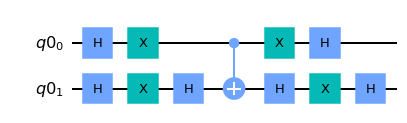

In [4]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr, name = 'C_0')
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser

diffuser(2).draw(output ='mpl')

In [5]:
def negative_gate():

    q_c = QuantumRegister(1)
    neg = QuantumCircuit(q_c)

    N = Operator(np.array([
        [-1, 0],
        [0, -1]
        ]))

    neg.unitary(N, q_c[:])
    return neg.to_gate(label='$-I$')

In [6]:
def rotation_2(n, i,j):
    diagonal_elements = [1]*(2**(2*n))
    diagonal_elements[i+j*2**n]= -1
    reflection = Diagonal(diagonal_elements)
    reflection.name = "$O$"
    return reflection.to_gate()


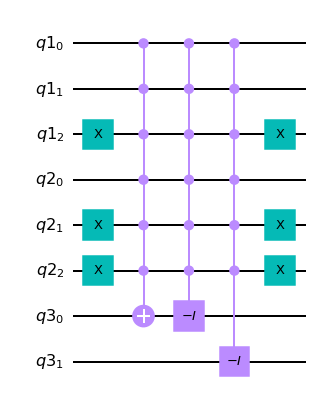

In [7]:
def rotation_2(n,i,j, m=2):
    
    # This gate has only effect on the marked vertex (i,j)
    
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(m)
    rotation_2 = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'C_marked')
    
    i=bin(i)[2:]
    j=bin(j)[2:]
    #print(i,j)
    
    #print('i =', i)
    
    r = n-len(i)
    #print('r_i=',r)
    for k in range(r):
        rotation_2.x(q_r_2[n-1-k])
    for k in range(len(i)):
        if i[k]=='0':
            rotation_2.x(q_r_2[len(i)-1-k])
            
    #print('j =', j)
            
    r = n-len(j)
    #print('r_j=',r)
    for k in range(r):
        rotation_2.x(q_r_1[n-1-k])
    for k in range(len(j)):
        #print(k)
        if j[k]=='0':
            rotation_2.x(q_r_1[len(j)-1-k])    
    
    rotation_2.mct(q_r_1[:]+q_r_2[:], q_c[0])
    
    
    #rotation_2.h(q_c[:])
    neg = negative_gate().control(2*n)
    rotation_2.append(neg, q_r_1[:]+q_r_2[:] + [q_c[0]])
    rotation_2.append(neg, q_r_1[:]+q_r_2[:] + [q_c[1]])
    
    #rotation_2.append(negative_gate(), [q_c[2]])
    
  
    #print('i =', i)
    
    r = n-len(i)
    #print('r_i=',r)
    for k in range(r):
        rotation_2.x(q_r_2[n-1-k])
    for k in range(len(i)):
        if i[k]=='0':
            rotation_2.x(q_r_2[len(i)-1-k])
            
    #print('j =', j)
            
    r = n-len(j)
    #print('r_j=',r)
    for k in range(r):
        rotation_2.x(q_r_1[n-1-k])
    for k in range(len(j)):
        #print(k)
        if j[k]=='0':
            rotation_2.x(q_r_1[len(j)-1-k])  
  
    
    return rotation_2


rotation_2(3,1,3).draw(output='mpl')

In [8]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r)
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc.to_gate(label='INCREMENT')

In [9]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r)
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec.to_gate(label='DECREMENT')

In [10]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'Shift')
    
    dec_j = decrement_gate(n)
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])

    
    dec_i = decrement_gate(n).control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).control(2)
    inc = increment_gate(n).control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    #shift.x( q_c[1])
        
    return shift.to_gate(label='SHIFT')

#shift_gate(2).draw(output ='mpl', style="bw", initial_state = True )

## Useful functions

In [11]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator).result()
    counts = result.get_counts(circuit)
    return counts

In [12]:
def show(n,counts, m=2, v = True):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        #i = i if i<2**(n-1) else i-(2**n)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        #j = j if j<2**(n-1) else j-(2**n)
        #print(num, "i ='", i, "',j ='",j,"'", counts[num])
        #grid[i + 2**(n-1)-1,j +2**(n-1)-1]= 1024 - counts[num]
        grid[i,j]+=counts[num]
    if v: 
        print(grid)
    return grid

## Search algorithm 1 : moving search

We applie 

$U'=S \cdot C' = C_0\otimes (I-2\left|v\right\rangle \left\langle v \right|)$ 


to the initial state :

$\left|\psi _0\right\rangle = H^n\left|0\right\rangle^n H^n\left|0\right\rangle^n  $

where :

$\left|v\right\rangle$ is the marked verticle

$C_0  = \frac{1}{2}\begin{pmatrix}
-1  & 1 & 1 & 1 \\
1  & -1 & 1 & 1 \\
1  & 1 & -1 & 1 \\
1  & 1 & 1 & -1 \\
\end{pmatrix}
$ is the grover's diffusion operator

$C_1 = - C_0  X_{0} $ is applied when on the marked vertex.

$S$ is the shift gate defined as : 


$S\left|{\rightarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\rightarrow }\right\rangle \left|{i+1}\right\rangle \left|{j}\right\rangle$



$S\left|{\leftarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\leftarrow }\right\rangle \left|{i-1}\right\rangle \left|{j}\right\rangle$



$S\left|{\uparrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\uparrow }\right\rangle \left|{i}\right\rangle \left|{j+1}\right\rangle$



$S\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j-1}\right\rangle$



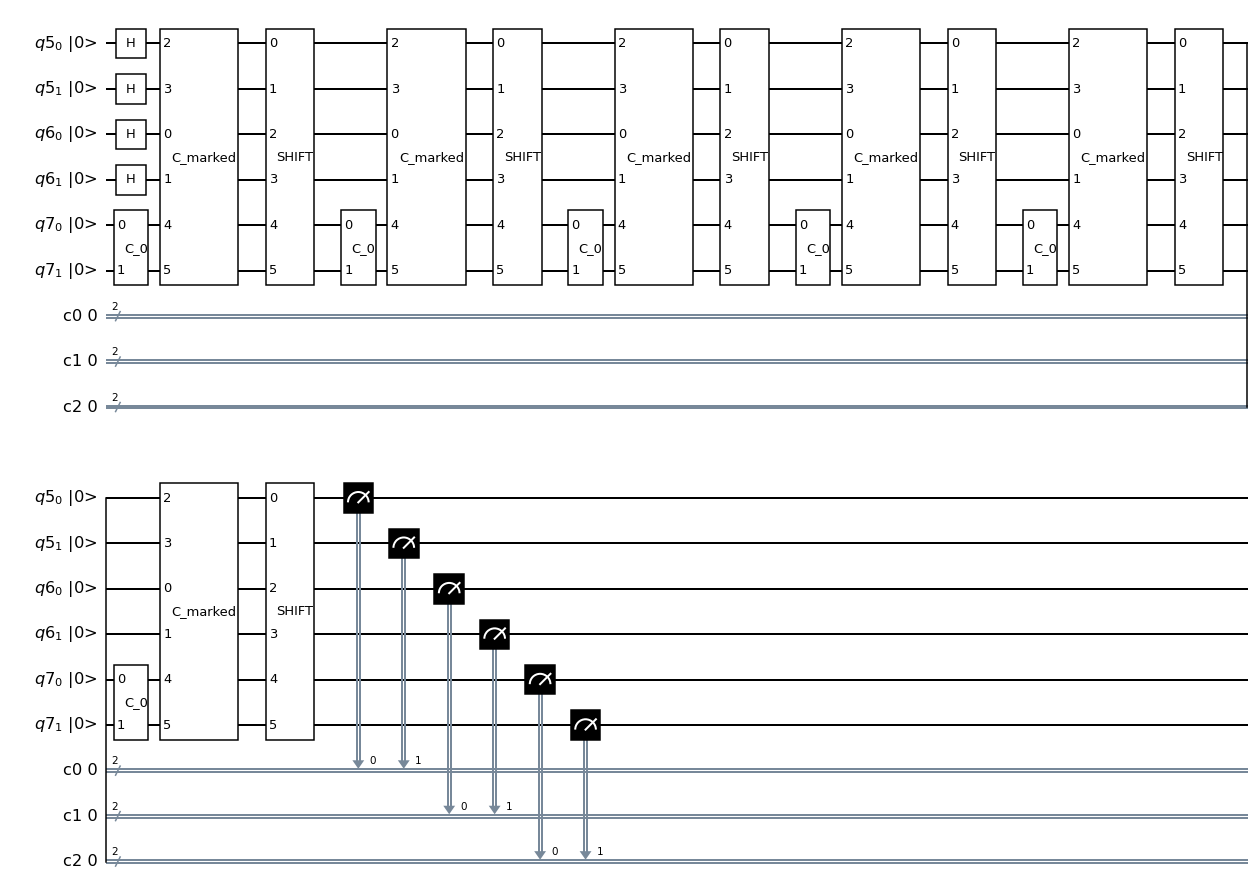

In [13]:
t = 6
n = 2

i,j = 1,2


q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(2)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(2)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

circuit.h(q_reg_i[:] + q_reg_j[:])
#circuit.h(q_coin[:])


coin = diffuser(2)
rotation = rotation_2(n,i,j)
shift = shift_gate(n)
    
for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(rotation, q_reg_j[:]+ q_reg_i[:]+q_coin[:])
    circuit.append(shift, q_reg_i[:] + q_reg_j[:] + q_coin[:])
    


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
circuit.draw(output ='mpl', style="bw", initial_state = True , filename = 'serch_grid_circuit.png')

In [14]:
counts = simulate(circuit)
#plot_histogram(counts)

[[139.  33.  52. 107.]
 [ 68.  50.  67.  59.]
 [ 47.  36.  54.  76.]
 [ 62.  54.  60.  60.]]


Text(0, 0.5, 'index j ')

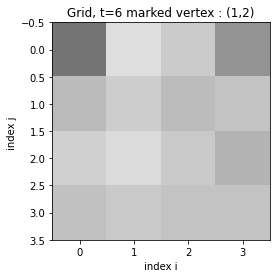

In [15]:
plt.imshow(show(n,counts)*4, interpolation='nearest',vmin=0, vmax=1024, cmap='binary')
plt.title("Grid, t="+str(t) +" marked vertex : (" + str(i) +","+str(j)+")")
plt.xlabel("index i")
plt.ylabel("index j ")

### Evolution :


![SegmentLocal](figures/moving.gif "segment")

## Search algorithm 2


$S$ is the shift gate is now defined as :


$S\left|{\leftarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\rightarrow }\right\rangle \left|{i+1}\right\rangle \left|{j}\right\rangle$



$S\left|{\leftarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\rightarrow }\right\rangle \left|{i-1}\right\rangle \left|{j}\right\rangle$



$S\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\uparrow }\right\rangle \left|{i1}\right\rangle \left|{j+1}\right\rangle$



$S\left|{\downarrow }\right\rangle \left|{i}\right\rangle \left|{j}\right\rangle =
\left|{\uparrow }\right\rangle \left|{i}\right\rangle \left|{j-1}\right\rangle$



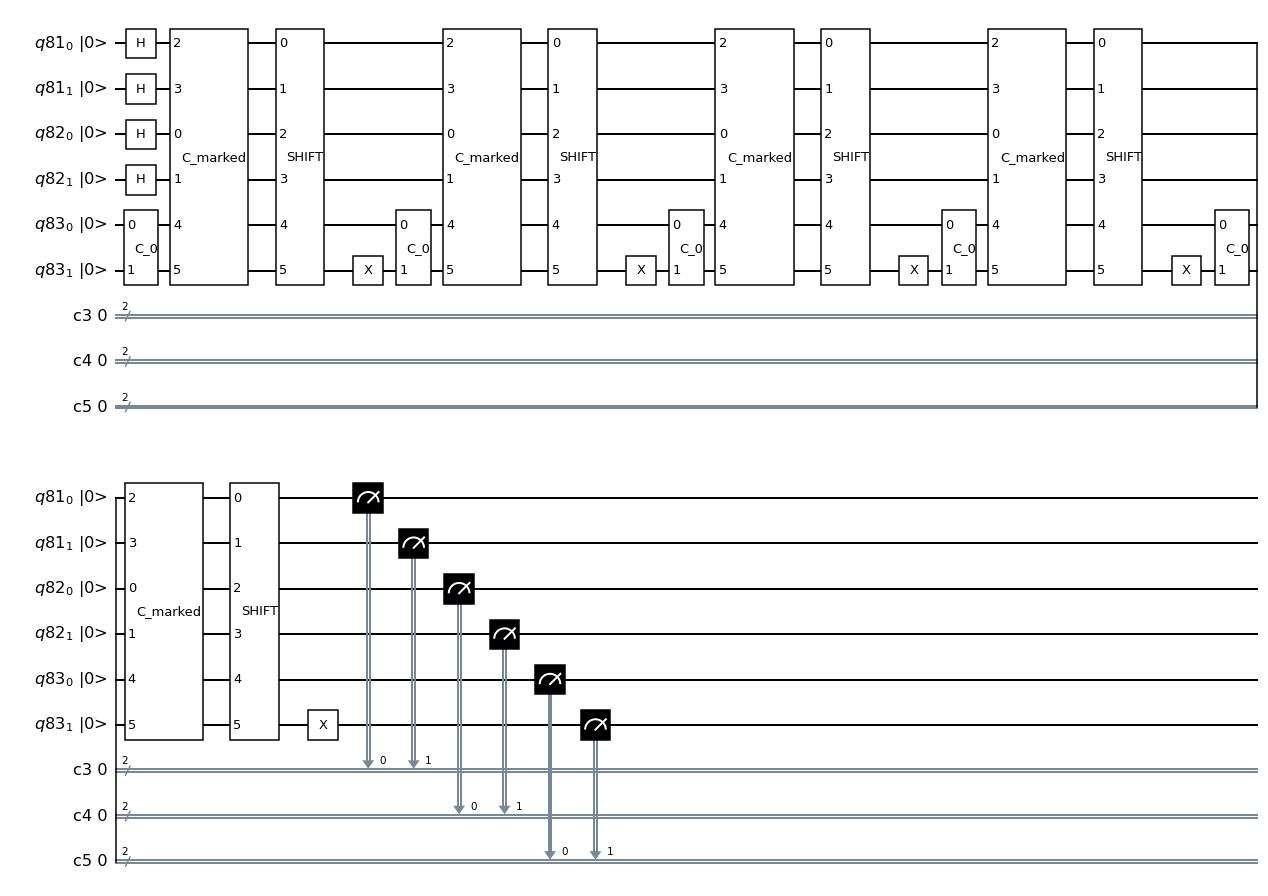

In [16]:
t = 5
n = 2

i,j = 1,2


q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(2)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(2)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

circuit.h(q_reg_i[:] + q_reg_j[:])
#circuit.h(q_coin[:])


coin = diffuser(2)
rotation = rotation_2(n,i,j)
shift = shift_gate(n)
    
for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(rotation, q_reg_j[:]+ q_reg_i[:]+ q_coin[:])
    circuit.append(shift, q_reg_i[:] + q_reg_j[:] + q_coin[:])
    circuit.x( q_coin[1])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
circuit.draw(output ='mpl', style="bw", initial_state = True )

In [17]:
counts = simulate(circuit)
#plot_histogram(counts)

[[ 64.  73.  63.  28.]
 [ 57.  41.  60.  50.]
 [ 62. 137.  69.  38.]
 [ 63. 120.  50.  49.]]


Text(0, 0.5, 'index j ')

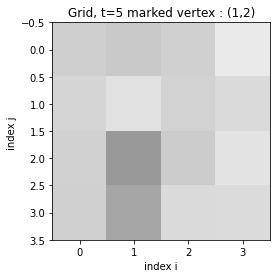

In [18]:
plt.imshow(show(n,counts)*3, interpolation='nearest',vmin=0, vmax=1024, cmap='binary')
plt.title("Grid, t="+str(t) +" marked vertex : (" + str(i) +","+str(j)+")")
plt.xlabel("index i")
plt.ylabel("index j ")

### Evolution 


![SegmentLocal](figures/flip_flop_search.gif "segment")

### Comparison

We generate multiple image of the grid to compare efficiency of the two previous algorithms.

In [ ]:
# to generate gif and save probabilities curves.

import pandas as pd 

def search(filename,p, n,i,j,vmax, v= False):
    Proba=[]

    for t in range(p): 


        q_reg_i = QuantumRegister(n)
        q_reg_j = QuantumRegister(n)
        q_coin = QuantumRegister(2)
        c_reg_i = ClassicalRegister(n)
        c_reg_j = ClassicalRegister(n)
        c_coin = ClassicalRegister(2)


        circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

        circuit.h(q_reg_i[:] + q_reg_j[:])
        #circuit.h(q_coin[:])


        coin = diffuser(2)
        rotation = rotation_2(n,i,j)
        shift = shift_gate(n)

        for _ in range(t) :
            circuit.append(rotation, q_reg_j[:]+ q_reg_i[:]+q_coin[:])
            circuit.append(coin, q_coin[:])
            circuit.append(shift, q_reg_i[:] + q_reg_j[:] + q_coin[:])
            circuit.x( q_coin[1])


        circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

        counts = simulate(circuit)

        grid = show(n,counts)
        Proba+= [grid[j][i]]

        plt.imshow((grid/1024), interpolation='nearest',vmin=0, vmax=vmax, cmap='binary') 
        plt.colorbar()


        plt.title("Grid, t="+str(t))
        plt.xlabel("index i")
        plt.ylabel("index j ")
        print('t = ',t)
        print('Proba = ',Proba)
        plt.savefig('image/'+filename+'_'+str(t)+'.png')
        plt.clf()
    pd.DataFrame(Proba).to_csv(filename+'.csv')
    return Proba

In [ ]:
filename ='flip_flop_loop'
p=20
n=3
i,j=1,2
vmax = 0.10

## To generate images, uncomment the following : 

# search(filename,p, n,i,j, vmax)

In [21]:
# Upload previous results

flip_flop_64 = pd.read_csv('2D_search_flip_flop_64.csv', sep=',')
moving_64 = pd.read_csv('2D_search_moving_64.csv', sep=',')
flip_flop_16 = pd.read_csv('2D_search_flip_flop_16.csv', sep=',')
flip_flop_256 = pd.read_csv('2D_search_flip_flop_256.csv', sep=',')

Text(0.5, 1.0, 'Moving and flip shift comparison')

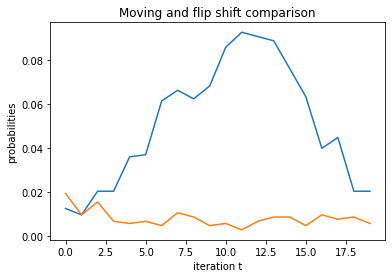

In [22]:
plt.plot(flip_flop_64['0']/1024, label = 'flip-flop')
plt.plot(moving_64['0']/1024, label = 'moving')
plt.xlabel('iteration t')
plt.ylabel('probabilities')
plt.title('Moving and flip shift comparison')

Text(0.5, 1.0, 'Using the flip-shift')

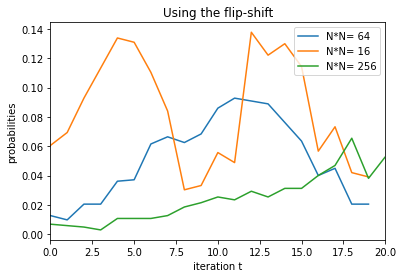

In [23]:
plt.plot(np.array(flip_flop_64['0']/1024), label = 'N*N= 64')
plt.plot(flip_flop_16['0']/1024, label = 'N*N= 16')
plt.plot(flip_flop_256['0']/1024,  label = 'N*N= 256')
plt.xlim([0, 20])
plt.legend()
plt.xlabel('iteration t')
plt.ylabel('probabilities')
plt.title('Using the flip-shift')

## Conclusion :

The search is more effective using the flip shift. Wa can also notice that the number of iteration required to have a maximum probability to select the marked vertex depends on N = 2^n (NxN is the number of verticles in the graph) .

Indeed, a calculation could proof that the query complexity is $\Omega (N)$ for the moving shift algorithm and $o(Nlog(N)$ for the flip shift algorithm.